In [1]:
import numpy as np
import pandas as pd
import time

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from boris_util import *

# Exploring the Dataset

First thing's first, let's load the dataset. I created a new function that loads up the dataset for me and converts it into a pandas dataframe for easy access. For more information on this, please see the `Data Cleaning` notebook

In [2]:
dataset = read_original_data('453_923_bundle_archive')
print(dataset.shape)
dataset.head()

Longest file has 396900 measurements
(585, 396901)


,0,1,2,3,4,5,6,7,8,9,...,396891,396892,396893,396894,396895,396896,396897,396898,396899,label
0,1.0,-3.0,-1.0,-7.0,-9.0,-2.0,-6.0,-5.0,-3.0,4.0,...,10.0,3.0,1.0,-4.0,-5.0,1.0,0.0,1.0,0.0,artifact
1,-2.0,3.0,-4.0,4.0,-3.0,2.0,-1.0,0.0,0.0,0.0,...,9.0,18.0,7.0,6.0,2.0,-6.0,0.0,-7.0,-6.0,artifact
2,6.0,-4.0,-9.0,-1.0,-4.0,1.0,-5.0,2.0,4.0,3.0,...,1.0,7.0,5.0,1.0,2.0,0.0,3.0,2.0,-3.0,artifact
3,-85.0,-198.0,-214.0,-173.0,-177.0,-206.0,-256.0,-274.0,-171.0,-33.0,...,-228.0,-271.0,-277.0,-248.0,-198.0,-166.0,-110.0,-74.0,-76.0,artifact
4,53.0,-35.0,47.0,170.0,340.0,436.0,535.0,639.0,647.0,569.0,...,534.0,440.0,435.0,375.0,238.0,67.0,-37.0,-71.0,32.0,artifact


Let's take a look at the class distribution to see if there is any concern of class imbalance

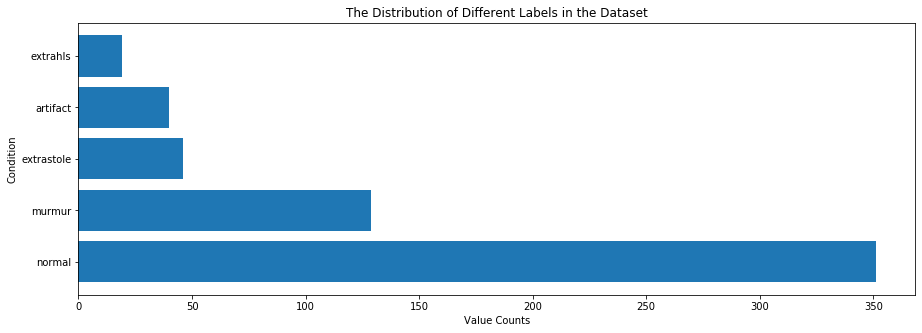

In [3]:
label_counts = dataset['label'].value_counts()

plt.figure(figsize=(15,5))
plt.barh(label_counts.index, label_counts.values)
plt.xlabel("Value Counts")
plt.ylabel("Condition")
plt.title("The Distribution of Different Labels in the Dataset")
plt.show()

There is certainly an issue of class imbalance here. A naive classifier could guess pretty well by simply guessing "Normal" on all the examples

## Basic Model - Logistic Regression

Let's start by establishing a baseline performance. I am just going to load the raw audio data as features (where each feature is an audio measurement) and see how well a simple logistic regression (linear model) and decision tree (non-linear model) will perform

In [41]:
class_mapping = {'artifact': 0, 
                 'extrahls': 1, 
                 'murmur': 2, 
                 'normal': 3,
                 'extrastole': 4}

In [43]:
from sklearn.model_selection import train_test_split


X = dataset.drop('label', axis=1)
y = dataset['label'].map(class_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y.values, random_state=1)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(468, 396900) (117, 396900)
(468,) (117,)


In [45]:
from sklearn.linear_model import LogisticRegression

fit_start = time.time()
my_model = LogisticRegression().fit(X_train, y_train)
fit_end = time.time()
print(f"Fitting took {round(fit_end - fit_start,2)} seconds")

train_acc = my_model.score(X_train, y_train)
test_acc = my_model.score(X_test, y_test)

Fitting took 47.6 seconds


In [46]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 100.0%
The test accuracy is 28.21%


Extremely suspicious results. There is clearly a very large sign of overfitting here. Let's explore how the logistic regression makes decisions.

Let's plot the coefficients as if they were an audio mask (which is really what they end up becoming).

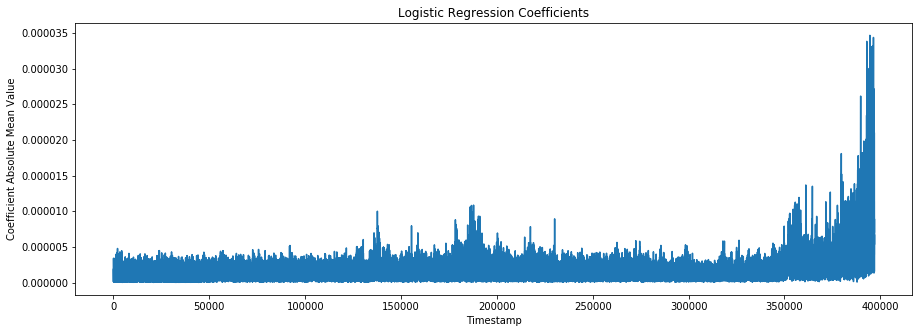

In [47]:
plt.figure(figsize=(15, 5))
plt.plot(np.abs(my_model.coef_).mean(axis=0))
plt.xlabel("Timestamp")
plt.ylabel("Coefficient Absolute Mean Value")
plt.title("Logistic Regression Coefficients")
plt.show()

Most of the decision is happening at the end of the sound bite. It looks like we can chop all audio clips to the last 10,000 sound measurements and get comparable results

In [48]:
X_truncated = X.iloc[:, -100000:]

X_train, X_test, y_train, y_test = train_test_split(X_truncated, y, test_size=0.2, stratify=y, random_state=1)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(468, 100000) (117, 100000)
(468,) (117,)


In [49]:
from sklearn.linear_model import LogisticRegression

fit_start = time.time()
my_model = LogisticRegression().fit(X_train, y_train)
fit_end = time.time()
print(f"Fitting took {round(fit_end - fit_start,2)} seconds")

train_acc = my_model.score(X_train, y_train)
test_acc = my_model.score(X_test, y_test)

print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

Fitting took 10.47 seconds
The training accuracy is 100.0%
The test accuracy is 29.06%


Interestingly for the logistic regression I got comparable performance with only $\frac{1}{3}$ of the run time.

## Basic Model - Decision Tree

As another baseline, I will train a decision tree to see if introducing non-linearity to the learning process produces better results

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y.values, random_state=1)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(468, 396900) (117, 396900)
(468,) (117,)


In [51]:
from sklearn.tree import DecisionTreeClassifier

fit_start = time.time()
# Let's set some regularization otherwise we know the tree will overfit
my_model = DecisionTreeClassifier(min_samples_leaf=2).fit(X_train, y_train)
fit_end = time.time()
print(f"Fitting took {round(fit_end - fit_start,2)} seconds")

train_acc = my_model.score(X_train, y_train)
test_acc = my_model.score(X_test, y_test)

Fitting took 90.73 seconds


In [52]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 96.79%
The test accuracy is 50.43%


Much better results! However, let's see how the model performs using the confusion matrix of the test set



In [53]:
from sklearn.metrics import plot_confusion_matrix

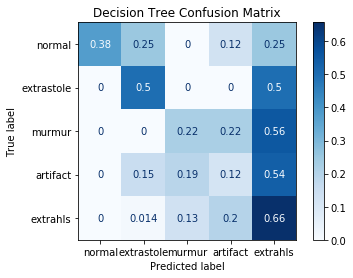

In [37]:
#plt.figure(figsize=(10, 10))
disp = plot_confusion_matrix(my_model, X_test, y_test,
                             display_labels=y_test.drop_duplicates(),
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title("Decision Tree Confusion Matrix")
plt.show()

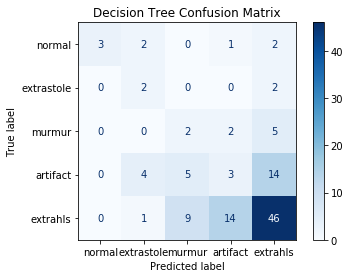

In [38]:
disp = plot_confusion_matrix(my_model, X_test, y_test,
                             display_labels=y_test.drop_duplicates(),
                             cmap=plt.cm.Blues,
                             normalize=None)
disp.ax_.set_title("Decision Tree Confusion Matrix")
plt.show()

In [39]:
y_test.value_counts()

normal        70
murmur        26
extrastole     9
artifact       8
extrahls       4
Name: label, dtype: int64